In [1]:
%pylab inline
rcParams['figure.figsize'] = (10, 4) #wide graphs by default
from __future__ import print_function
from __future__ import division

Populating the interactive namespace from numpy and matplotlib


In [3]:
from scipy.io import wavfile
sr, src = wavfile.read('media/THX.wav')
sr2, src2 = wavfile.read('media/passport.wav')

# Downmix
src_mono = sum(src.astype(float)/src.shape[1], axis=1).astype(src.dtype)
# Normalize
abs_max = max(abs(src_mono.min().astype(float)), abs(src_mono.max().astype(float)))
src_mono_norm = src_mono.astype(float) / abs_max

In [4]:
from IPython.display import Audio
Audio(src_mono, rate=sr)

# Root Mean Squared

$$x_{\mathrm{rms}} =
\sqrt{ \frac{1}{n} \left( x_1^2 + x_2^2 + \cdots + x_n^2 \right) }.$$

http://en.wikipedia.org/wiki/Root_mean_square

In [5]:
win_size = 2048
hop = 1024
window_start = arange(0, len(src_mono_norm), hop)

window_start

array([      0,    1024,    2048, ..., 1100800, 1101824, 1102848])

In [7]:
rms = []

for start in window_start:
    w = src_mono_norm[start: start+win_size].astype(float)
    rms_inst = sqrt(mean(w**2))
    rms.append(rms_inst)

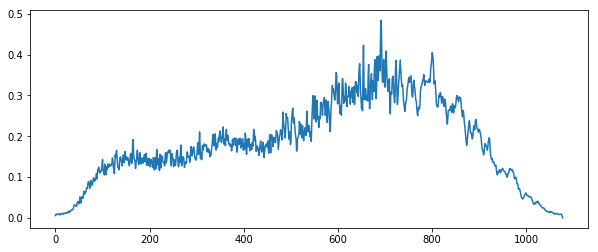

In [8]:
plot(rms)

In [24]:
win_sizes = [512, 1024, 2048, 4096]

rms_windows = []

for win_size in win_sizes:
    hop = win_size/2
    window_start = arange(0, len(src_mono_norm), hop) # XXX why does this make floats??!
    rms = []
    for start in window_start:
        s = start.astype('int')
        w = src_mono_norm[s: s+win_size].astype(float)
        rms_inst = sqrt(mean(w**2))
        rms.append(rms_inst)
    rms_windows.append(rms)

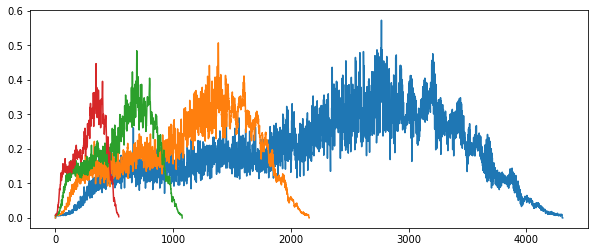

In [25]:
for rms_plot in rms_windows:
    plot(rms_plot)

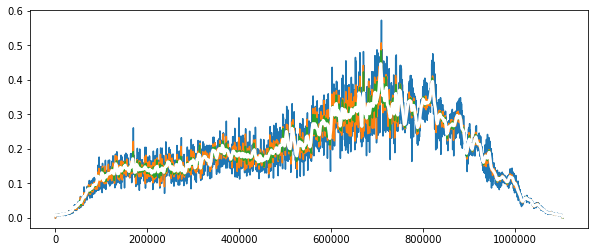

In [26]:
for rms_plot in rms_windows:
    plot(linspace(0, len(src_mono_norm), len(rms_plot)), rms_plot)

plot(linspace(0, len(src_mono_norm), len(rms_windows[-1])), rms_windows[-1], lw=3, color='w')

## Energy envelope

Half-wave rectification and low-pass filtering

In [27]:
src_rect = src_mono_norm *sign(src_mono_norm)

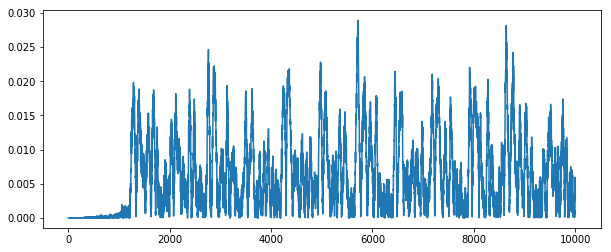

In [28]:
plot(src_rect[0:10000])

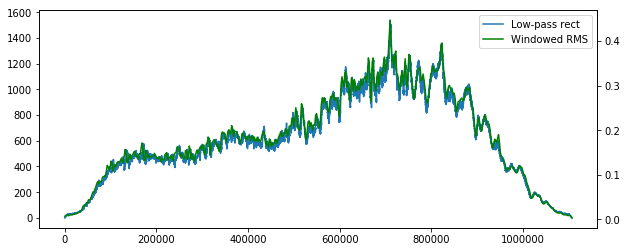

In [29]:
ee = convolve(src_rect, ones(4096))
p1 = plot(ee)
twinx()
p2 = plot(linspace(0, len(ee), len(rms_windows[-1])), rms_windows[-1], 'g')
legend((p1+p2),['Low-pass rect', 'Windowed RMS'])

Decimation or other type of point reduction would be useful after this.

# Zero crossing rate


Speech recognition: Aye, Y.Y.; , "Speech Recognition Using Zero-Crossing Features," Electronic Computer Technology, 2009 International Conference on , vol., no., pp.689-692, 20-22 Feb. 2009

http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=4796052&tag=1

Percussive sound discrimination:

Gouyon, F., Pachet, F., & Delerue, O. (2000). On the use of zero-crossing rate for an application of classification of percussive sounds. DAFx G-6 conference on Digital Audio Effects, 3–8. Retrieved from http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.18.7006&rep=rep1&type=pdf

For very clean sounds can be used to detect pitch.

It also tends to correlate to high frequency content.

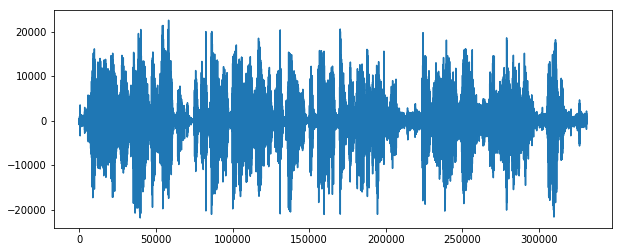

In [30]:
in_sig = src2.astype(float)
plot(in_sig)

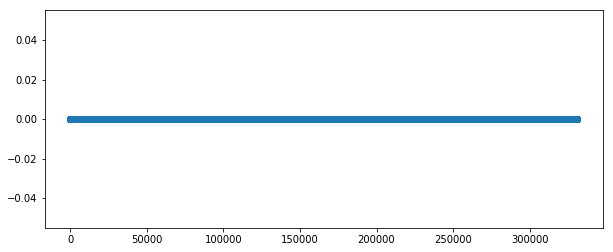

In [31]:
zc = argwhere((in_sig[:-1]*in_sig[1:]) <= 0)

#zc = r_[zc, argwhere(in_sig == 0)]

plot(zc, zeros_like(zc), 'o')

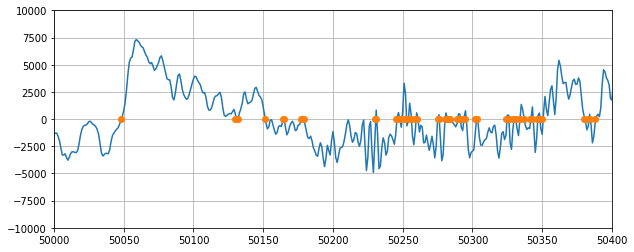

In [36]:
plot(in_sig)
plot(zc, zeros_like(zc), 'o')
grid()
xlim(50000, 50400);
ylim((-10000, 10000));

In [37]:
len(zc)

26163

In [38]:
len(in_sig)/44100.0 #duration of the sample

7.507891156462585

In [39]:
len(zc)/(len(in_sig)/44100.0) #Global ZCR

3484.7335230052736

In [48]:
# XXX why was this definition missing?? 
# is this a homework solution??
def windowed_zcr(sig_in, winsize, hop, sr = 1.0):
    l = len(sig_in)
    win_start = arange(0, l - winsize, hop)
    zcr = zeros((len(win_start)))
    for i, start in enumerate(win_start):
        sl = sig_in[start: start + winsize].astype(float)
        zcr[i] = (sr/float(winsize)) * sum(sl[:-1]*sl[1:] < 0)

    times = win_start + winsize/2
    return times/float(sr), zcr

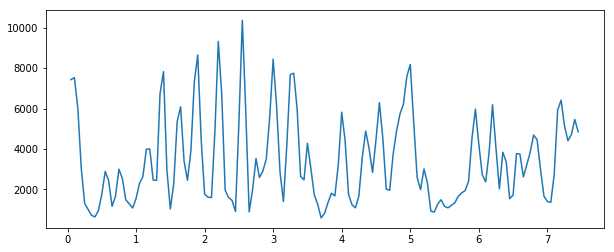

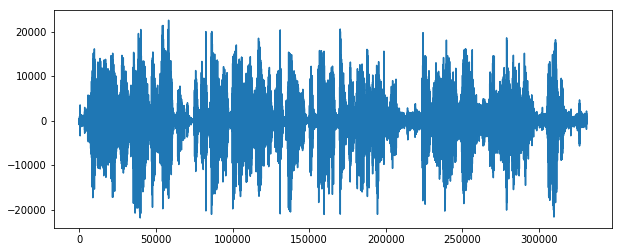

In [49]:
times, zcr = windowed_zcr(src2, 4410, 2205, sr2)
plot(times, zcr)
figure()
plot(in_sig)

In [50]:
from IPython.display import Audio
Audio(in_sig, rate=sr)

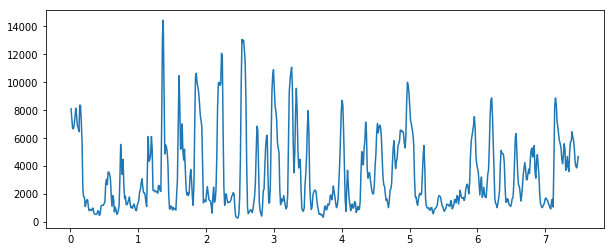

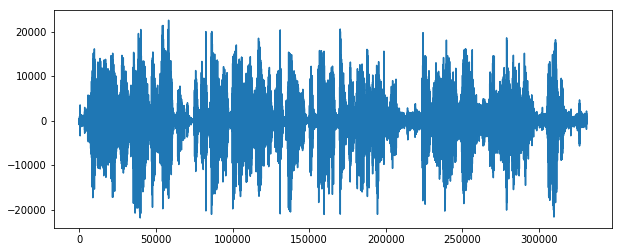

In [51]:
times, zcr = windowed_zcr(src2, 1024, 512, sr2)
plot(times, zcr)
figure()
plot(in_sig)

# Spectral shape features

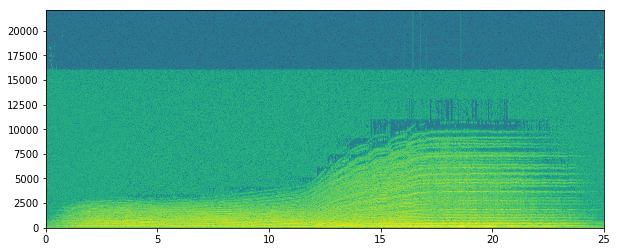

In [52]:
Pxx, freqs, times, im = specgram(src_mono_norm, NFFT=2048, Fs=sr, window=window_hanning, noverlap=1024);

In [53]:
Pxx.shape

(1025, 1076)

The time-varying power spectrum is stored in *Pxx*. Each column (second dimension) holds a single spectral frame.

*specgram* assumes a real only input signal. For that reason the spectrum contains $\frac{N}{2}+1\ $ points

In [54]:
freqs.shape, times.shape

((1025,), (1076,))

In [55]:
freqs[30]

645.99609375

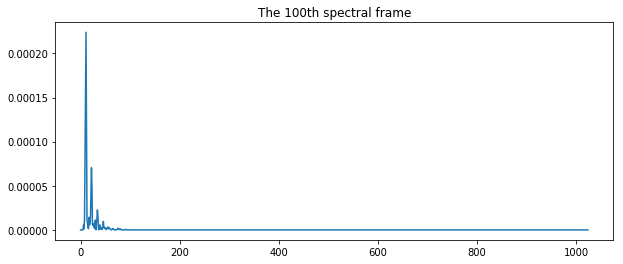

In [56]:
plot(Pxx[:, 99])
title('The 100th spectral frame')

## Spectral Centroid

$$sc = \frac{\sum\limits_f{ X(f) f}}{\sum\limits_f{X(f)} } $$

*mpeg7:SpectralCentroid*

The spectral centroid correlates to pitch and brightness

In [57]:
27/8

3.375

In [58]:
X = sqrt(Pxx)
sc = sum(X[:,99]*freqs)/sum(X[:,99])
print(sc)

892.394746531


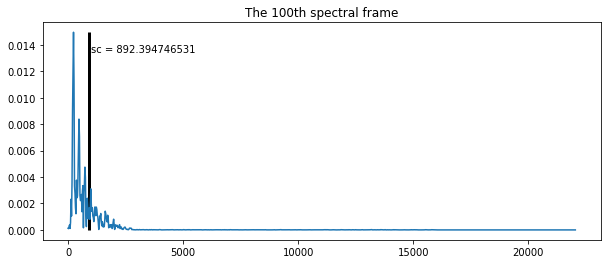

In [59]:
plot(freqs,X[:, 99])
title('The 100th spectral frame')
vlines([sc], X[:,99].min(), X[:,99].max(), lw=3)
text(sc*1.1, X[:,99].max() * 0.9, 'sc = ' + str(sc))

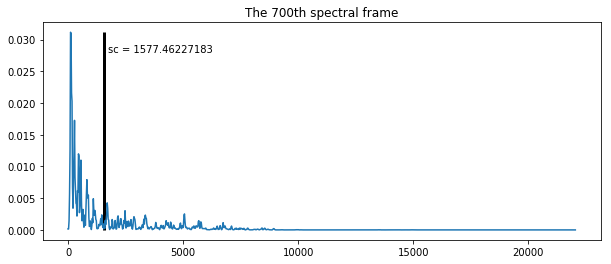

In [60]:
sc = sum(X[:,699]*freqs)/sum(X[:,699])
plot(freqs,X[:, 699])
title('The 700th spectral frame')
vlines([sc], X[:,699].min(), X[:,699].max(), lw=3)
text(sc*1.1, X[:,699].max() * 0.9, 'sc = ' + str(sc))

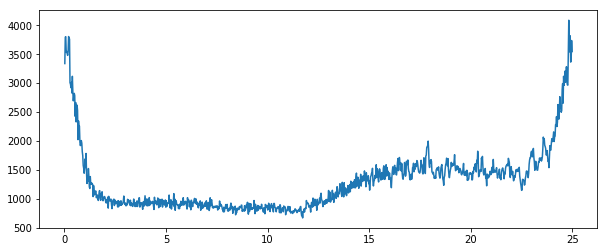

In [61]:
centroid = []

for spec in X.T:
    sc = sum(spec*freqs)/sum(spec)
    centroid.append(sc)

plot(times, centroid)

## Spectral Spread

Measures how diffuse or focused the spectrum is around its centroid. It is the statistical measure of variance.

*mpeg7:AudioSpectrumSpread*

$$\operatorname{Var}(X) = \frac{1}{n}\sum_{i=1}^n (x_i - \mu)^2$$

$$\mu = \frac{1}{n}\sum_{i=1}^n x_i $$

http://en.wikipedia.org/wiki/Variance

In [62]:
ss = var(X[:,99])
print(ss)

9.40361259916e-07


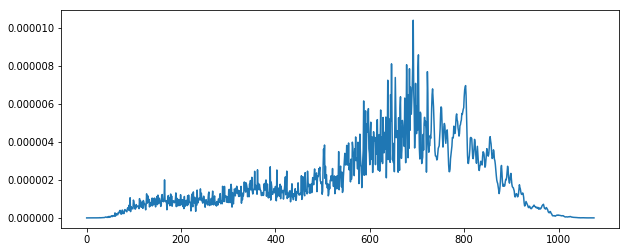

In [63]:
spread = []

for spec in X.T:
    ss = var(spec)
    spread.append(ss)

plot(spread)

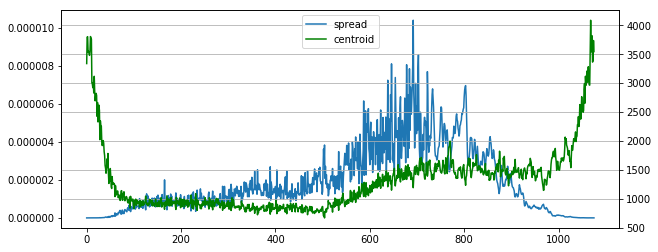

In [64]:
p1 = plot(spread)
twinx()
p2 = plot(centroid, 'g')

legend((p1 + p2), ('spread', 'centroid'), loc='best')
grid()

In [65]:
from IPython.display import Audio
Audio(src_mono_norm, rate=sr)

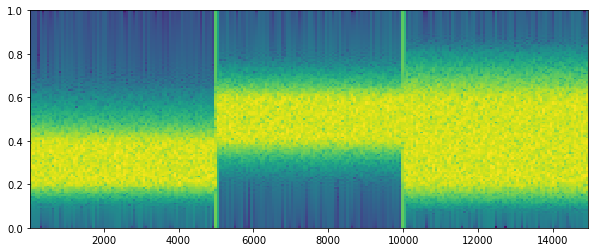

In [70]:
from scipy.signal import butter, lfilter

noise = random.random(10000) - 0.5
b, a = butter(8, [0.2, 0.4], btype='band')
b2, a2 = butter(8, [0.4, 0.6], btype='band')
b3, a3 = butter(8, [0.2, 0.6], btype='band')
filt_noise = r_[lfilter(b,a, noise), lfilter(b2,a2, noise), lfilter(b3,a3, noise)]
Pxx, freqs,times, im = specgram(filt_noise, Fs = 2);
# XXX why did i have to add 'Fs = 2'???
# http://stackissue.com/PyWavelets/pywt/update-wp_scalogram-demo-work-with-matplotlib-20-276.html
# http://matplotlib.org/api/mlab_api.html#matplotlib.mlab.specgrams

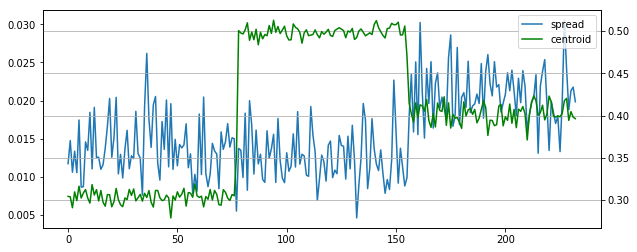

In [71]:
X = sqrt(Pxx)

centroid = []
for spec in X.T:
    sc = sum(spec*freqs)/sum(spec)
    centroid.append(sc)

spread = []
for spec in X.T:
    ss = var(spec)
    spread.append(ss)

p1 = plot(spread)
twinx()
p2 = plot(centroid, 'g')

legend((p1 + p2), ('spread', 'centroid'), loc='best')
grid()

## Spectral skewness

A measure of the asymmetry around the centroid. (Also called the third order moment of a distribution)

In [72]:
from scipy.stats import moment

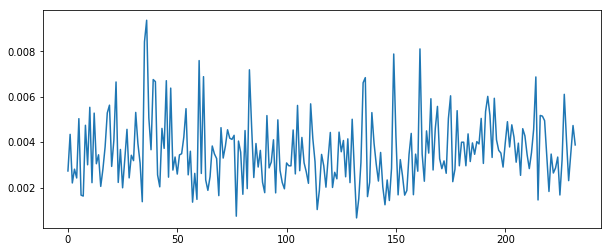

In [73]:
skewness = []
for spec in X.T:
    ss = moment(spec, moment=3)
    skewness.append(ss)

plot(skewness)

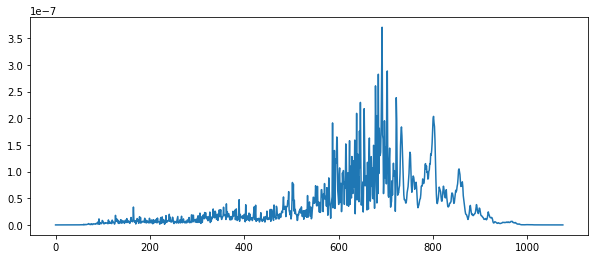

In [74]:
Pxx, freqs, times, im = specgram(src_mono_norm, NFFT=2048, Fs=sr, window=window_hanning, noverlap=1024);

X = sqrt(Pxx)
skewness = []
for spec in X.T:
    ss = moment(spec, moment=3)
    skewness.append(ss)

clf()
plot(skewness)

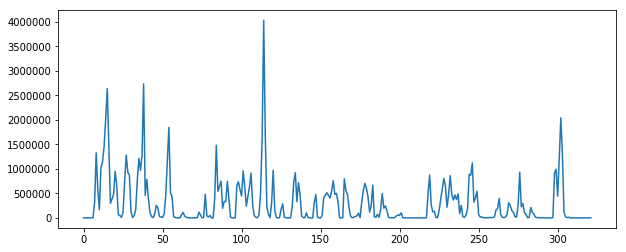

In [75]:
Pxx, freqs, times, im = specgram(src2, NFFT=2048, Fs=sr, window=window_hanning, noverlap=1024);

X = sqrt(Pxx)
skewness = []
for spec in X.T:
    ss = moment(spec, moment=3)
    skewness.append(ss)

clf()
plot(skewness)

## Spectral kurtosis

http://en.wikipedia.org/wiki/Kurtosis

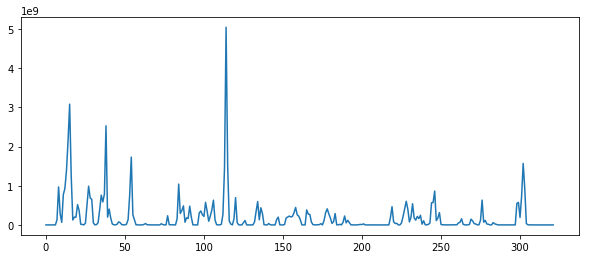

In [76]:
kurtosis = []
for spec in X.T:
    sk = moment(spec, moment=4)
    kurtosis.append(sk)

plot(kurtosis)

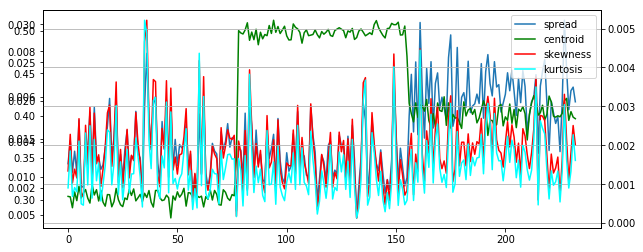

In [78]:
Pxx, freqs,times, im = specgram(filt_noise, Fs = 2);
clf()
X = sqrt(Pxx)

centroid = []
spread = []
kurtosis = []
skewness = []
for spec in X.T:
    sc = sum(spec*freqs)/sum(spec)
    centroid.append(sc)
    ssk = moment(spec, moment=3)
    skewness.append(ssk)
    ss = var(spec)
    spread.append(ss)
    
    sk = moment(spec, moment=4)
    kurtosis.append(sk)

p1 = plot(spread)
twinx()
p2 = plot(centroid, 'g')
twinx()
p3 = plot(skewness, 'r')
twinx()
p4 = plot(kurtosis, 'cyan')

legend((p1 + p2 + p3 +p4), ('spread', 'centroid', 'skewness', 'kurtosis'), loc='best')
grid()

## Spectral flux

Process:

*    Amplitude spectrum is normalized
*    Sum of squared changes in spectrum from the previous one

Used often for onset detection, as this is where there is often large spectral flux.

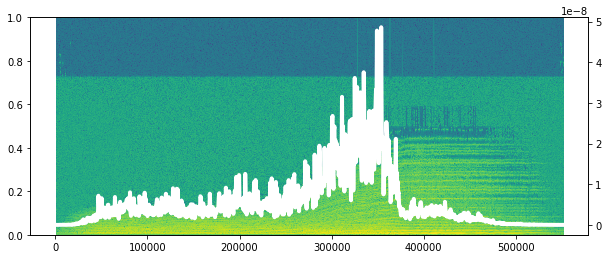

In [80]:
Pxx3, freqs3,times3, im = specgram(src_mono_norm, NFFT=2048, noverlap=1024, Fs = 2);

X_mag = sqrt(Pxx3)

X1 = X_mag[:,:-1]/sum(X_mag[:,:-1])
X2 = X_mag[:, 1:]/sum(X_mag[:, 1:])

spec_diff = X2 - X1
flux = sum(spec_diff**2, axis=0)

twinx()
plot(linspace(0, times3.max(), len(flux)), flux, lw=4, color='w')

There is another similar definition:

Dixon, S. (2006) Onset Detection Revisited, in Proceedings of the 9th International Conference on Digital Audio Effects (DAFx-06), Montreal, Canada, September 18-20, 2006

http://www.dafx.ca/proceedings/papers/p_133.pdf

In this definition, there is no normalization, and instead of finding the sum of the square of the changes, the sum of the half-wave rectified difference is used.

http://en.wikipedia.org/wiki/Rectifier#Half-wave_rectification

# Rhythm and Pitch features

Rhythm

* Tempo
* Beats

Pitch

* Monophonic
* Polyphonic

In [85]:
superstition_sr, superstition = wavfile.read("media/superstition.wav")

In [86]:
def windowed_rms(input_sig, win_size, hop=None, sr=1.0):
    if not hop:
        hop = winsize/2
    rms = []
    window_start = arange(0, len(input_sig), hop)
    
    for start in window_start:
        w = input_sig[start: start+win_size].astype(float)
        rms_inst = sqrt(mean(w**2))
        rms.append(rms_inst)
    times = (window_start + win_size/2)/float(sr)
    return times, rms

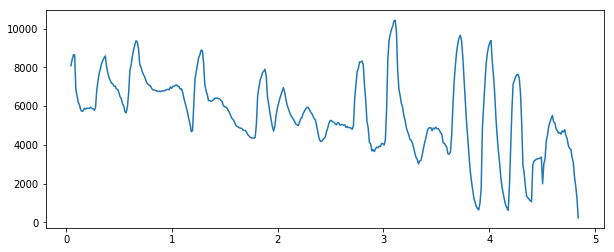

In [87]:
times, super_rms = windowed_rms(superstition, 4096, 512, 44100)
plot(times, super_rms)

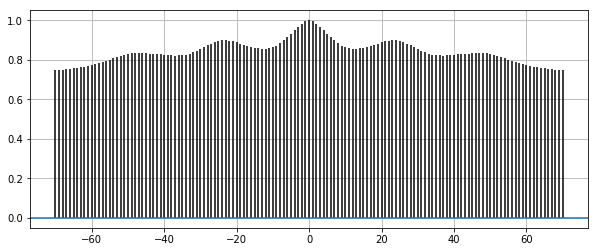

In [104]:
lags, cc, lines, line = acorr(super_rms, maxlags=70)
grid();

In [106]:
argmax(cc[80:]) + 80

93

In [107]:
lags[argmax(cc[80:]) + 80]

23

In [108]:
44100.0/23

1917.391304347826

Doesn't make sense! # XXX doesn't make sense! -- ky

In [110]:
times[23]

0.31346938775510202

In [111]:
1.0/times[23]

3.190104166666667

In [114]:
bpm = 60.0/times[23]/2
print(bpm)

95.703125


Texture windows, Machine learning/Clustering/Classification

By: Andrés Cabrera mantaraya36@gmail.com

For Course MAT 201A at UCSB

This ipython notebook is licensed under the CC-BY-NC-SA license: http://creativecommons.org/licenses/by-nc-sa/4.0/

![http://i.creativecommons.org/l/by-nc-sa/3.0/88x31.png](http://i.creativecommons.org/l/by-nc-sa/3.0/88x31.png)